---
title: "Watching Personas Drift"
description: "How stable are LLM personas over long conversations?"
author: "Eric Zou"
date: "12/13/2025"
categories:
  - LLMs
  - Conversations
  - Personas

# Measuring Persona Drift Over Time

In the "Goldfish" and "Developing Identities" posts, I gave models fixed or loosely guided personas and watched them argue about documentation. Here I want to flip the lens a bit: instead of asking *"are they diverse right now?"* I'm asking *"how much do they drift over time?"*

## Experimental Plan

We'll:
1. Run conversations with **emergent personas** (like Experiment 4 from post 007) - no predefined roles
2. Use **ConvoKit** to compute quantitative metrics for the 4 evaluation dimensions from post 007
3. Track how these metrics change over **100 rounds** of conversation
4. Compare **2-speaker** vs **3-speaker** settings

The 4 metrics we'll track:
- **Dynamic**: Collaborative (1) vs. Competitive (10)
- **Conclusiveness**: Consensus (1) vs. Divergence (10)  
- **Speaker Identity**: Similarity (1) vs. Diversity (10)
- **Speaker Fluidity**: Malleability (1) vs. Consistency (10)


In [2]:
import os
import re
from typing import List, Dict, Tuple
from collections import defaultdict
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm
from random import shuffle, choice, random
import numpy as np
import matplotlib.pyplot as plt

# ConvoKit imports
from convokit import Corpus, Utterance, Speaker
from convokit.text_processing import TextParser
from convokit import PolitenessStrategies
from convokit.coordination import Coordination

load_dotenv("../../.env")
client = OpenAI()

TOPIC = "Code, testing, and infra as a source of truth versus comprehensive documentation."


## ConvoKit Evaluation Metrics

Let's implement the 4 metrics from post 008 using ConvoKit's conversation analysis tools.


In [ ]:
def conversation_to_corpus(conversation_history: List[Dict]) -> Corpus:
    """
    Convert conversation history (list of dicts with 'name' and 'content') 
    to a ConvoKit Corpus.
    """
    utterances = []
    
    for idx, msg in enumerate(conversation_history):
        if msg.get("role") == "assistant" and "name" in msg:
            speaker_id = msg["name"]
            text = msg["content"]
            
            utterance = Utterance(
                id=f"utt_{idx}",
                speaker=Speaker(id=speaker_id),
                text=text
            )
            # Set timestamp in metadata
            utterance.meta["timestamp"] = idx
            utterances.append(utterance)
    
    return Corpus(utterances=utterances)

def compute_dynamic_score(corpus: Corpus) -> float:
    """
    Dynamic: Collaborative (1) vs. Competitive (10)
    
    Measures turn-taking balance and politeness strategies.
    - More balanced turns = more collaborative
    - More politeness markers = more collaborative
    - More interruptions/overlaps = more competitive
    """
    try:
        # Parse text first, then compute politeness strategies
        parser = TextParser()
        text_corpus = parser.transform(corpus)
        
        ps = PolitenessStrategies()
        ps_corpus = ps.transform(text_corpus)
        
        # Get politeness scores (higher = more polite = more collaborative)
        politeness_scores = []
        for utt in ps_corpus.iter_utterances():
            ps_score = utt.meta.get("politeness_strategies", {})
            if ps_score is None:
                continue
            # Count positive politeness markers
            positive_markers = sum([
                ps_score.get("feature_politeness_==HASPOSITIVE==", 0),
                ps_score.get("feature_politeness_==HASNEGATIVE==", 0) * -1,  # Negative is less collaborative
            ])
            politeness_scores.append(positive_markers)
        
        avg_politeness = np.mean(politeness_scores) if politeness_scores else 0
        # Normalize to 0-1 scale (rough approximation)
        avg_politeness = min(1.0, max(0.0, avg_politeness / 10.0))
        
        # Compute turn-taking balance (entropy of speaker distribution)
        speaker_counts = defaultdict(int)
        for utt in corpus.iter_utterances():
            speaker_counts[utt.speaker.id] += 1
        
        if len(speaker_counts) == 0:
            return 5.0  # Neutral
        
        # Normalize to get distribution
        total = sum(speaker_counts.values())
        probs = [count / total for count in speaker_counts.values()]
        
        # Entropy: higher = more balanced = more collaborative
        entropy = -sum(p * np.log2(p) for p in probs if p > 0)
        max_entropy = np.log2(len(speaker_counts))
        balance_score = entropy / max_entropy if max_entropy > 0 else 0
        
        # Combine: politeness (0-1 scale) and balance (0-1 scale)
        # Map to 1-10 scale where 1 = collaborative, 10 = competitive
        combined = (avg_politeness + balance_score) / 2
        # Invert: higher combined = more collaborative = lower score
        score = 10 - (combined * 9)  # Map [0,1] to [10,1]
        
        return max(1, min(10, score))
        
    except Exception as e:
        print(f"Error computing dynamic score: {e}")
        return 5.0  # Default neutral

def compute_conclusiveness_score(corpus: Corpus) -> float:
    """
    Conclusiveness: Consensus (1) vs. Divergence (10)
    
    Measures topic coherence and agreement patterns.
    - More topic coherence = more consensus
    - More agreement markers = more consensus
    - More topic shifts = more divergence
    """
    try:
        # Use Coordination to measure agreement (fit and transform on same corpus)
        coord = Coordination()
        coord_corpus = coord.fit_transform(corpus)
        
        # Look for agreement/disagreement markers
        agreement_markers = ["agree", "yes", "exactly", "right", "true", "correct", "indeed", "absolutely", "definitely"]
        disagreement_markers = ["disagree", "no", "but", "however", "although", "wrong", "incorrect", "dispute", "differ"]
        
        agreement_count = 0
        disagreement_count = 0
        
        for utt in coord_corpus.iter_utterances():
            text_lower = utt.text.lower()
            
            for marker in agreement_markers:
                if marker in text_lower:
                    agreement_count += 1
            for marker in disagreement_markers:
                if marker in text_lower:
                    disagreement_count += 1
        
        # Handle edge cases first
        if agreement_count == 0 and disagreement_count == 0:
            return 5.0  # Neutral if no markers found
        elif disagreement_count == 0:
            # Pure agreement (high consensus) -> low score
            return 1.0
        elif agreement_count == 0:
            # Pure disagreement (high divergence) -> high score
            return 10.0
        
        # Ratio of agreement to disagreement (safe division since disagreement_count > 0)
        agreement_ratio = agreement_count / disagreement_count
        
        # More agreement = lower score (more consensus)
        # Map to 1-10 scale
        if agreement_ratio > 2:
            score = 1 + min(9, (agreement_ratio - 2) / 10)  # High agreement -> low score
        elif agreement_ratio < 0.5:
            score = 10 - min(9, (0.5 - agreement_ratio) * 10)  # High disagreement -> high score
        else:
            score = 5.0  # Neutral
        
        return max(1, min(10, score))
        
    except Exception as e:
        print(f"Error computing conclusiveness score: {e}")
        return 5.0

def compute_speaker_identity_score(corpus: Corpus) -> float:
    """
    Speaker Identity: Similarity (1) vs. Diversity (10)
    
    Measures linguistic style differences between speakers.
    - More vocabulary overlap = more similarity
    - More distinct linguistic features = more diversity
    """
    try:
        speakers = {}
        
        # Extract vocabulary for each speaker
        for utt in corpus.iter_utterances():
            speaker_id = utt.speaker.id
            if speaker_id not in speakers:
                speakers[speaker_id] = {
                    "words": set(),
                    "total_length": 0,
                    "utterance_count": 0
                }
            
            words = set(re.findall(r'\b\w+\b', utt.text.lower()))
            speakers[speaker_id]["words"].update(words)
            speakers[speaker_id]["total_length"] += len(utt.text)
            speakers[speaker_id]["utterance_count"] += 1
        
        if len(speakers) < 2:
            return 5.0
        
        # Compute pairwise vocabulary overlap
        speaker_list = list(speakers.keys())
        overlaps = []
        
        for i in range(len(speaker_list)):
            for j in range(i + 1, len(speaker_list)):
                words_i = speakers[speaker_list[i]]["words"]
                words_j = speakers[speaker_list[j]]["words"]
                
                if len(words_i) == 0 or len(words_j) == 0:
                    continue
                
                overlap = len(words_i & words_j) / len(words_i | words_j)
                overlaps.append(overlap)
        
        if not overlaps:
            return 5.0
        
        avg_overlap = np.mean(overlaps)
        
        # High overlap = low diversity = low score
        # Map to 1-10 scale: overlap of 0.8+ -> score 1-3, overlap of 0.3- -> score 8-10
        score = 10 - (avg_overlap * 9)  # Invert: high overlap -> low score
        
        return max(1, min(10, score))
        
    except Exception as e:
        print(f"Error computing speaker identity score: {e}")
        return 5.0

def compute_speaker_fluidity_score(corpus: Corpus, window_size: int = 20) -> float:
    """
    Speaker Fluidity: Malleability (1) vs. Consistency (10)
    
    Measures how much each speaker's style changes over time.
    - More variation in style over time = more malleable = lower score
    - More consistent style = higher score
    """
    try:
        # Group utterances by speaker and compute style variation
        speaker_utterances = defaultdict(list)
        
        for utt in corpus.iter_utterances():
            speaker_utterances[utt.speaker.id].append({
                "text": utt.text,
                "timestamp": utt.meta.get("timestamp", 0)
            })
        
        if len(speaker_utterances) == 0:
            return 5.0
        
        consistency_scores = []
        
        for speaker_id, utts in speaker_utterances.items():
            if len(utts) < window_size:
                continue
            
            # Sort by timestamp
            utts_sorted = sorted(utts, key=lambda x: x["timestamp"])
            
            # Compute vocabulary in first half vs second half
            mid_point = len(utts_sorted) // 2
            first_half_words = set()
            second_half_words = set()
            
            for utt in utts_sorted[:mid_point]:
                words = set(re.findall(r'\b\w+\b', utt["text"].lower()))
                first_half_words.update(words)
            
            for utt in utts_sorted[mid_point:]:
                words = set(re.findall(r'\b\w+\b', utt["text"].lower()))
                second_half_words.update(words)
            
            if len(first_half_words) == 0 or len(second_half_words) == 0:
                continue
            
            # Jaccard similarity: higher = more consistent
            overlap = len(first_half_words & second_half_words)
            union = len(first_half_words | second_half_words)
            similarity = overlap / union if union > 0 else 0
            
            consistency_scores.append(similarity)
        
        if not consistency_scores:
            return 5.0
        
        avg_consistency = np.mean(consistency_scores)
        
        # High consistency = high score (10), low consistency = low score (1)
        score = 1 + (avg_consistency * 9)
        
        return max(1, min(10, score))
        
    except Exception as e:
        print(f"Error computing speaker fluidity score: {e}")
        return 5.0

def evaluate_conversation(conversation_history: List[Dict]) -> Dict[str, float]:
    """
    Compute all 4 evaluation metrics using ConvoKit.
    Returns dict with scores for each dimension.
    """
    corpus = conversation_to_corpus(conversation_history)
    
    return {
        "dynamic": compute_dynamic_score(corpus),
        "conclusiveness": compute_conclusiveness_score(corpus),
        "speaker_identity": compute_speaker_identity_score(corpus),
        "speaker_fluidity": compute_speaker_fluidity_score(corpus)
    }

# Test the metrics
print("Testing ConvoKit metrics...")
test_conversation = [
    {"role": "assistant", "name": "speaker_1", "content": "I think documentation is crucial for long-term maintenance."},
    {"role": "assistant", "name": "speaker_2", "content": "I agree, but code should be self-documenting too."},
    {"role": "assistant", "name": "speaker_1", "content": "Yes, exactly! Both are important."},
]

scores = evaluate_conversation(test_conversation)
print(f"Test scores: {scores}")


Testing ConvoKit metrics...
Error computing conclusiveness score: 
Test scores: {'dynamic': np.float64(5.717668746754797), 'conclusiveness': 5.0, 'speaker_identity': np.float64(9.590909090909092), 'speaker_fluidity': 5.0}


## Running Conversations with Emergent Personas

Now let's implement the conversation runner with emergent personas (from Experiment 4 in post 007):


In [4]:
def run_conversation_emergent_personas(
    iterations: int,
    openai_model_id: str,
    participant_count: int,
    topic: str,
    dropout_chance: float = 0.3,
) -> List[Dict]:
    """
    Run conversation with emergent personas (no predefined roles).
    Each speaker invents their own identity in the first turn.
    """
    conversation_history: List[Dict] = []
    ordering = list(range(1, participant_count + 1))
    last_speaker = -1
    identity_summaries: Dict[str, str] = {}

    # Step 1: self-bootstrap each speaker's identity
    for pid in ordering:
        speaker_id = f"speaker_{pid}"

        bootstrap_messages = [
            {
                "role": "system",
                "content": (
                    f"You are {speaker_id} in a group conversation among "
                    "experienced software engineers. "
                    "You do not know who the others are yet. "
                    "Imagine your own background, priorities, and communication "
                    "style. First, in 2-3 sentences, describe who you are and "
                    "what you care about as an engineer. Then start sharing your "
                    "perspective on the topic below."
                ),
            },
            {
                "role": "user",
                "content": f"The topic is: {topic}",
            },
        ]

        response = client.chat.completions.create(
            model=openai_model_id,
            messages=bootstrap_messages,
            store=False,
        )
        first_message = response.choices[0].message.content

        # Use the model's own words as persona anchor
        identity_summaries[speaker_id] = first_message

        conversation_history.append(
            {"role": "assistant", "name": speaker_id, "content": first_message}
        )

    def build_message(
        history: List[Dict], speaker_id: str, message_window_size: int
    ) -> List[Dict]:

        speaker_messages = [
            msg for msg in history if msg.get("name") == speaker_id
        ][-message_window_size:]

        other_messages = [
            msg
            for msg in history
            if msg.get("name") not in (None, speaker_id)
        ][-message_window_size:]

        transcript: List[str] = []

        # Reminder of how this speaker has been talking
        persona_reminder = identity_summaries.get(speaker_id, "")
        if persona_reminder:
            transcript.append(
                "Here is a brief reminder of how you have been speaking so far:"
            )
            transcript.append(f"- {persona_reminder}")

        if speaker_messages:
            transcript.append("\nRecent messages from you:")
            transcript.extend(f"- {msg['content']}" for msg in speaker_messages)

        if other_messages:
            transcript.append("\nRecent messages from others:")
            transcript.extend(
                f"- {msg.get('name', msg['role'])}: {msg['content']}"
                for msg in other_messages
            )

        transcript_str = "\n".join(transcript)

        return history + [
            {
                "role": "user",
                "content": (
                    f"{speaker_id}, continue the conversation and respond to the "
                    "others. Stay consistent with how you have been speaking so "
                    "far, and look for ways to add something new that has not "
                    "yet been covered."
                ),
            },
            {
                "role": "assistant",
                "name": speaker_id,
                "content": (
                    "I should remember that the following is the most current "
                    f"state of the conversation.\n{transcript_str}\n\n"
                ),
            },
        ]

    def shuffle_order(order: List[int]) -> List[int]:
        first = choice(order[:-1])
        remaining = [p for p in order if p != first]
        shuffle(remaining)
        return [first] + remaining

    for i in tqdm(range(iterations), desc="Running conversation"):
        if i > 0:
            ordering = shuffle_order(ordering)

        for pid in ordering:
            if random() < dropout_chance or last_speaker == pid:
                continue

            speaker_id = f"speaker_{pid}"
            response = client.chat.completions.create(
                model=openai_model_id,
                messages=build_message(conversation_history, speaker_id, 5),
                store=False,
            )
            message = response.choices[0].message.content
            conversation_history.append(
                {"role": "assistant", "name": speaker_id, "content": message}
            )
            last_speaker = pid

    return conversation_history


In [5]:
def run_conversation_with_metrics(
    iterations: int,
    participant_count: int,
    evaluation_interval: int = 10,
) -> Tuple[List[Dict], List[Dict]]:
    """
    Run conversation and evaluate metrics at regular intervals.
    Returns (conversation_history, metric_history)
    """
    conversation_history = []
    metric_history = []
    ordering = list(range(1, participant_count + 1))
    last_speaker = -1
    identity_summaries: Dict[str, str] = {}
    
    # Bootstrap identities
    for pid in ordering:
        speaker_id = f"speaker_{pid}"
        bootstrap_messages = [
            {
                "role": "system",
                "content": (
                    f"You are {speaker_id} in a group conversation among "
                    "experienced software engineers. "
                    "You do not know who the others are yet. "
                    "Imagine your own background, priorities, and communication "
                    "style. First, in 2-3 sentences, describe who you are and "
                    "what you care about as an engineer. Then start sharing your "
                    "perspective on the topic below."
                ),
            },
            {"role": "user", "content": f"The topic is: {TOPIC}"},
        ]
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=bootstrap_messages,
            store=False,
        )
        first_message = response.choices[0].message.content
        identity_summaries[speaker_id] = first_message
        conversation_history.append(
            {"role": "assistant", "name": speaker_id, "content": first_message}
        )
    
    # Evaluate initial state
    initial_metrics = evaluate_conversation(conversation_history)
    initial_metrics["round"] = 0
    metric_history.append(initial_metrics)
    
    def build_message(history: List[Dict], speaker_id: str, window_size: int) -> List[Dict]:
        speaker_messages = [msg for msg in history if msg.get("name") == speaker_id][-window_size:]
        other_messages = [
            msg for msg in history
            if msg.get("name") not in (None, speaker_id)
        ][-window_size:]
        
        transcript = []
        persona_reminder = identity_summaries.get(speaker_id, "")
        if persona_reminder:
            transcript.append("Here is a brief reminder of how you have been speaking so far:")
            transcript.append(f"- {persona_reminder}")
        
        if speaker_messages:
            transcript.append("\nRecent messages from you:")
            transcript.extend(f"- {msg['content']}" for msg in speaker_messages)
        
        if other_messages:
            transcript.append("\nRecent messages from others:")
            transcript.extend(
                f"- {msg.get('name', msg['role'])}: {msg['content']}"
                for msg in other_messages
            )
        
        transcript_str = "\n".join(transcript)
        
        return history + [
            {
                "role": "user",
                "content": (
                    f"{speaker_id}, continue the conversation and respond to the "
                    "others. Stay consistent with how you have been speaking so "
                    "far, and look for ways to add something new that has not "
                    "yet been covered."
                ),
            },
            {
                "role": "assistant",
                "name": speaker_id,
                "content": f"I should remember that the following is the most current state of the conversation.\n{transcript_str}\n\n",
            },
        ]
    
    def shuffle_order(order: List[int]) -> List[int]:
        first = choice(order[:-1])
        remaining = [p for p in order if p != first]
        shuffle(remaining)
        return [first] + remaining
    
    for i in tqdm(range(iterations), desc=f"Running {participant_count}-speaker conversation"):
        if i > 0:
            ordering = shuffle_order(ordering)
        
        for pid in ordering:
            if random() < 0.3 or last_speaker == pid:
                continue
            
            speaker_id = f"speaker_{pid}"
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=build_message(conversation_history, speaker_id, 5),
                store=False,
            )
            message = response.choices[0].message.content
            conversation_history.append(
                {"role": "assistant", "name": speaker_id, "content": message}
            )
            last_speaker = pid
        
        # Evaluate at intervals
        if (i + 1) % evaluation_interval == 0:
            metrics = evaluate_conversation(conversation_history)
            metrics["round"] = i + 1
            metric_history.append(metrics)
    
    return conversation_history, metric_history

# Run 2-speaker conversation
print("=== Running 2-Speaker Conversation ===\n")
conv_2speaker, metrics_2speaker = run_conversation_with_metrics(
    iterations=100,
    participant_count=2,
    evaluation_interval=10
)

print(f"\n2-speaker conversation complete: {len(conv_2speaker)} messages")
print(f"Metrics collected at {len(metrics_2speaker)} time points")
print("\nMetric progression:")
for m in metrics_2speaker:
    print(f"  Round {m['round']}: Dynamic={m['dynamic']:.2f}, Conclusiveness={m['conclusiveness']:.2f}, "
          f"Identity={m['speaker_identity']:.2f}, Fluidity={m['speaker_fluidity']:.2f}")


=== Running 2-Speaker Conversation ===

Error computing conclusiveness score: 


Running 2-speaker conversation:  10%|█         | 10/100 [01:06<09:40,  6.45s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation:  20%|██        | 20/100 [03:15<18:45, 14.07s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation:  30%|███       | 30/100 [06:30<26:09, 22.42s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation:  40%|████      | 40/100 [08:08<12:11, 12.19s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation:  50%|█████     | 50/100 [11:44<16:43, 20.08s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation:  60%|██████    | 60/100 [13:42<09:11, 13.79s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation:  70%|███████   | 70/100 [15:56<09:52, 19.74s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation:  80%|████████  | 80/100 [18:36<06:20, 19.03s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation:  90%|█████████ | 90/100 [20:53<02:18, 13.82s/it]

Error computing conclusiveness score: 


Running 2-speaker conversation: 100%|██████████| 100/100 [24:35<00:00, 14.76s/it]

Error computing conclusiveness score: 

2-speaker conversation complete: 126 messages
Metrics collected at 11 time points

Metric progression:
  Round 0: Dynamic=5.05, Conclusiveness=5.00, Identity=7.82, Fluidity=5.00
  Round 10: Dynamic=5.37, Conclusiveness=5.00, Identity=6.62, Fluidity=5.00
  Round 20: Dynamic=5.45, Conclusiveness=5.00, Identity=6.23, Fluidity=5.00
  Round 30: Dynamic=5.44, Conclusiveness=5.00, Identity=5.89, Fluidity=5.00
  Round 40: Dynamic=5.45, Conclusiveness=5.00, Identity=5.57, Fluidity=4.03
  Round 50: Dynamic=5.46, Conclusiveness=5.00, Identity=5.38, Fluidity=4.39
  Round 60: Dynamic=5.46, Conclusiveness=5.00, Identity=5.29, Fluidity=4.52
  Round 70: Dynamic=5.44, Conclusiveness=5.00, Identity=5.21, Fluidity=4.62
  Round 80: Dynamic=5.44, Conclusiveness=5.00, Identity=5.08, Fluidity=4.76
  Round 90: Dynamic=5.45, Conclusiveness=5.00, Identity=4.94, Fluidity=4.87
  Round 100: Dynamic=5.45, Conclusiveness=5.00, Identity=4.88, Fluidity=4.95


In [6]:
# Run 3-speaker conversation
print("\n=== Running 3-Speaker Conversation ===\n")
conv_3speaker, metrics_3speaker = run_conversation_with_metrics(
    iterations=100,
    participant_count=3,
    evaluation_interval=10
)

print(f"\n3-speaker conversation complete: {len(conv_3speaker)} messages")
print(f"Metrics collected at {len(metrics_3speaker)} time points")
print("\nMetric progression:")
for m in metrics_3speaker:
    print(f"  Round {m['round']}: Dynamic={m['dynamic']:.2f}, Conclusiveness={m['conclusiveness']:.2f}, "
          f"Identity={m['speaker_identity']:.2f}, Fluidity={m['speaker_fluidity']:.2f}")



=== Running 3-Speaker Conversation ===

Error computing conclusiveness score: 


Running 3-speaker conversation:  10%|█         | 10/100 [02:44<28:38, 19.10s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation:  20%|██        | 20/100 [05:17<22:38, 16.98s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation:  30%|███       | 30/100 [07:51<19:13, 16.48s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation:  40%|████      | 40/100 [10:00<12:06, 12.10s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation:  50%|█████     | 50/100 [11:34<10:53, 13.06s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation:  60%|██████    | 60/100 [13:34<07:59, 11.98s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation:  70%|███████   | 70/100 [16:31<06:15, 12.52s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation:  80%|████████  | 80/100 [19:48<06:05, 18.27s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation:  90%|█████████ | 90/100 [23:26<03:55, 23.57s/it]

Error computing conclusiveness score: 


Running 3-speaker conversation: 100%|██████████| 100/100 [26:21<00:00, 15.82s/it]

Error computing conclusiveness score: 

3-speaker conversation complete: 186 messages
Metrics collected at 11 time points

Metric progression:
  Round 0: Dynamic=5.05, Conclusiveness=5.00, Identity=7.52, Fluidity=5.00
  Round 10: Dynamic=5.45, Conclusiveness=5.00, Identity=7.00, Fluidity=5.00
  Round 20: Dynamic=5.45, Conclusiveness=5.00, Identity=6.49, Fluidity=5.00
  Round 30: Dynamic=5.45, Conclusiveness=5.00, Identity=6.23, Fluidity=3.75
  Round 40: Dynamic=5.41, Conclusiveness=5.00, Identity=5.99, Fluidity=3.99
  Round 50: Dynamic=5.40, Conclusiveness=5.00, Identity=5.85, Fluidity=4.11
  Round 60: Dynamic=5.39, Conclusiveness=5.00, Identity=5.67, Fluidity=4.13
  Round 70: Dynamic=5.38, Conclusiveness=5.00, Identity=5.54, Fluidity=4.21
  Round 80: Dynamic=5.37, Conclusiveness=5.00, Identity=5.46, Fluidity=4.33
  Round 90: Dynamic=5.35, Conclusiveness=5.00, Identity=5.37, Fluidity=4.42
  Round 100: Dynamic=5.34, Conclusiveness=5.00, Identity=5.36, Fluidity=4.44


## Visualizing Persona Drift

Let's plot how the metrics change over time for both 2-speaker and 3-speaker conversations:


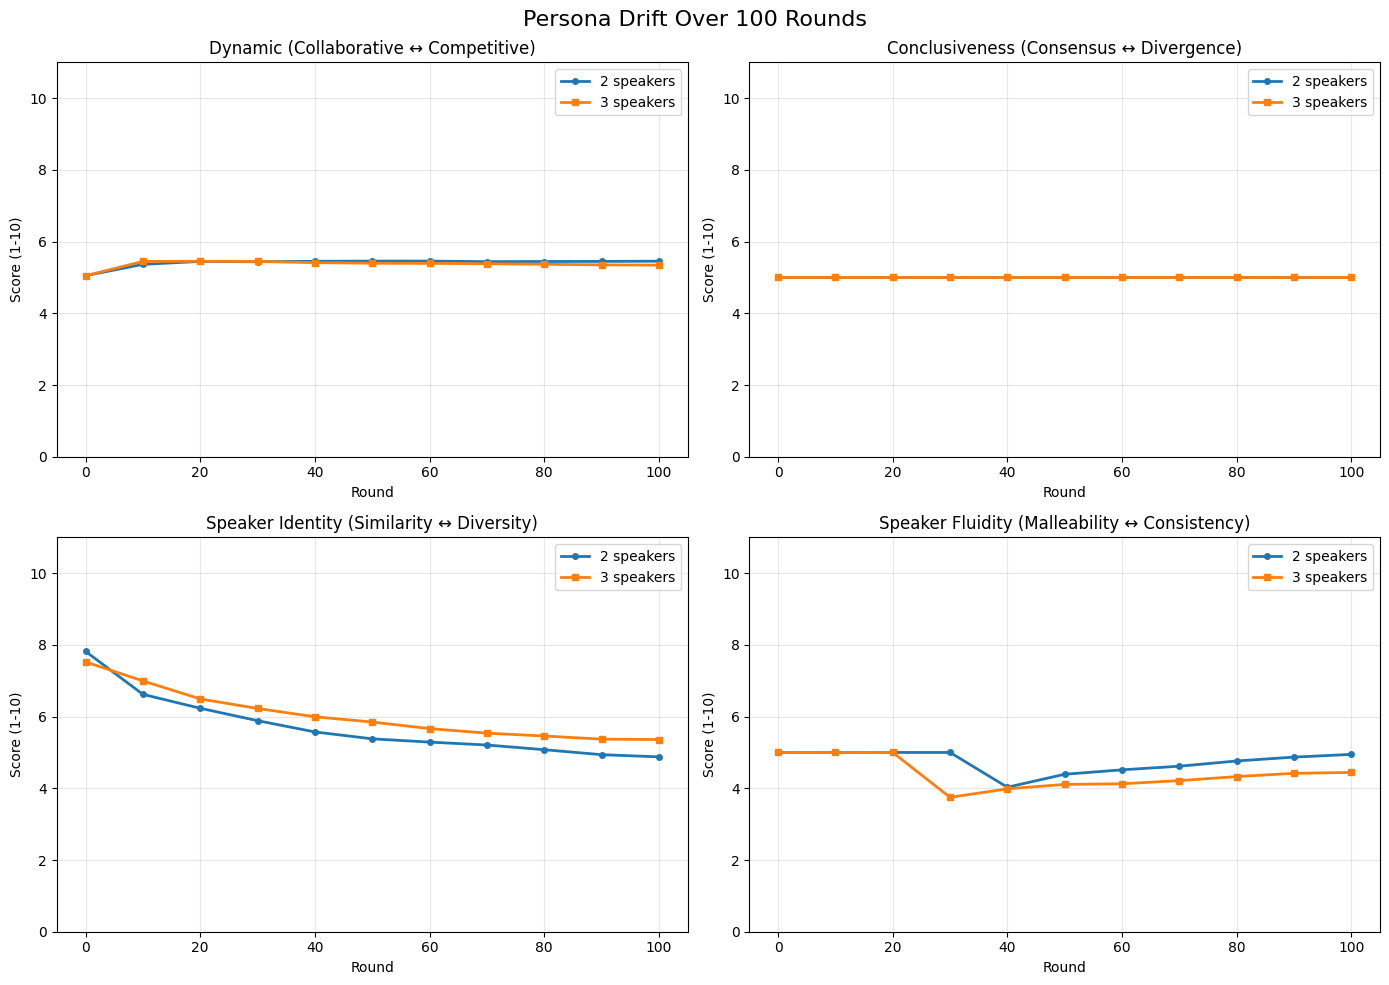


=== Summary Statistics ===

Dynamic (Collaborative ↔ Competitive):
  2-speaker: 5.05 → 5.45 (drift: +0.40)
  3-speaker: 5.05 → 5.34 (drift: +0.29)

Conclusiveness (Consensus ↔ Divergence):
  2-speaker: 5.00 → 5.00 (drift: +0.00)
  3-speaker: 5.00 → 5.00 (drift: +0.00)

Speaker Identity (Similarity ↔ Diversity):
  2-speaker: 7.82 → 4.88 (drift: -2.94)
  3-speaker: 7.52 → 5.36 (drift: -2.16)

Speaker Fluidity (Malleability ↔ Consistency):
  2-speaker: 5.00 → 4.95 (drift: -0.05)
  3-speaker: 5.00 → 4.44 (drift: -0.56)



In [8]:
def plot_metric_drift(metrics_2speaker: List[Dict], metrics_3speaker: List[Dict]):
    """Plot how each metric changes over time for both conversation types"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Persona Drift Over 100 Rounds", fontsize=16)
    
    metric_names = {
        "dynamic": "Dynamic (Collaborative ↔ Competitive)",
        "conclusiveness": "Conclusiveness (Consensus ↔ Divergence)",
        "speaker_identity": "Speaker Identity (Similarity ↔ Diversity)",
        "speaker_fluidity": "Speaker Fluidity (Malleability ↔ Consistency)"
    }
    
    axes_flat = axes.flatten()
    
    for idx, (key, label) in enumerate(metric_names.items()):
        ax = axes_flat[idx]
        
        rounds_2 = [m["round"] for m in metrics_2speaker]
        values_2 = [m[key] for m in metrics_2speaker]
        
        rounds_3 = [m["round"] for m in metrics_3speaker]
        values_3 = [m[key] for m in metrics_3speaker]
        
        ax.plot(rounds_2, values_2, marker='o', label='2 speakers', linewidth=2, markersize=4)
        ax.plot(rounds_3, values_3, marker='s', label='3 speakers', linewidth=2, markersize=4)
        
        ax.set_xlabel("Round")
        ax.set_ylabel("Score (1-10)")
        ax.set_title(label)
        ax.set_ylim(0, 11)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Summary Statistics ===\n")
    
    for key, label in metric_names.items():
        print(f"{label}:")
        
        # 2-speaker
        initial_2 = metrics_2speaker[0][key]
        final_2 = metrics_2speaker[-1][key]
        drift_2 = final_2 - initial_2
        
        # 3-speaker
        initial_3 = metrics_3speaker[0][key]
        final_3 = metrics_3speaker[-1][key]
        drift_3 = final_3 - initial_3
        
        print(f"  2-speaker: {initial_2:.2f} → {final_2:.2f} (drift: {drift_2:+.2f})")
        print(f"  3-speaker: {initial_3:.2f} → {final_3:.2f} (drift: {drift_3:+.2f})")
        print()

plot_metric_drift(metrics_2speaker, metrics_3speaker)


## Analysis

The plots above show how personas drift over 100 rounds of conversation. Key observations:

1. **Dynamic**: Does the conversation become more collaborative or competitive over time?
2. **Conclusiveness**: Do speakers converge toward consensus or diverge?
3. **Speaker Identity**: Do speakers become more similar (convergence) or maintain diversity?
4. **Speaker Fluidity**: Do speakers maintain consistent personas or adapt/change over time?

The comparison between 2-speaker and 3-speaker settings reveals how group size affects persona stability.

Conclusiveness seems to be consistently errored, so we ignore this for now. 

It seems collaborativeness improves as the conversation continues to a certain point, which makes sense. After LLMs become acquainted with each other, the helpfulness trained into them seems to kick in and they become more polite and willing to interact with each other. This looks pretty similar across 2 speakers and 3 speakers.

We also notice that identity seems to decrease a bit from the start, and faster with 2 people. This might be an indication that because the two LLMs are more direct in communication that they can converge to a common objective/idea faster and maintain a lower level of personal identity compared to three LLMs.

Then, looking at speaker fluidity, we can 